In [1]:
import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.backends.backend_pdf import PdfPages
import random
import pingouin
import os

#plots.py
# . . .
def plot_lines(df, linewidth = 1, figsize = (40,20),
               secondary_y = None, legend=True,
               h_zero = True, pp = None, 
               save_fig = False):
    
    fig, ax = plt.subplots(figsize = figsize)    
    # If no secondary_y (axis), plot all variables at once
    df.dropna().plot.line(linewidth = linewidth, ax = ax, secondary_y=secondary_y, legend = legend)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(x,2) for x in vals]) 
    if h_zero: ax.axhline(0, ls="--", color = "k")
    
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")  
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + filename[:50] + " line.png", 
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def corr_matrix_heatmap(df, save_fig = False, pp = None):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(20,20))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(df, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = df.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
#     plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(df.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "w")  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title("Correlation", fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    if save_fig:
        try:
            os.mkdir("plots")
        except:
            pass
        plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " corrMatrix.png",
            bbox_inches = "tight")

        if pp != None: pp.savefig(fig, bbox_inches="tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, 
                       figsize = (40, 20),
                       pp = None, total_var = False,
                      title = False):
    fig, ax = plt.subplots(figsize = figsize)
    # df.plot.area() created a stacked plot
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax,
                                c = "k",label = total_var, 
                                ls = "--")
    # place legend in top left corner of plot
    # format legend so that there are two columns of names
    ax.legend(loc = 2, ncol = 2)
    if title != False:
        plt.title(title)
        
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "Q"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()
            
    return df

In [2]:

data_codes = {"Total Debt":"TODNS",
              "Federal Debt": "FGSDODNS",
              "State and Local Debt":"SLGSDODNS",
              "Commercial and Industrial Loans":"TOTCI",
              "Total Loans, Excluding Federal Government":"ASTLL",
              "Nominal GDP":"GDP",
              "Real GDP":"GDPC1",
              "Expected Inflation: 5 Year Breakeven Rate":"T5YIE",
              "CPI: Urban Consumption":"CPIAUCSL",
              "Federal Funds Rate": "DFF",
              "Balance Sheet: Total Assets": "WALCL",
              "Currency in Circulation": "WCURCIR",
              "Unemployment Rate": "UNRATE",
              "Aaa Rate":"AAA",
              "10 Year Treasury Rate": "DGS10",


              
}


start = datetime.datetime(1950, 1, 1)
end =datetime.datetime.today()

annual_div = {"Q":4,
             "W":52,
             "M":12}
# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
if "data_gathered" not in locals():
    freq = "Q"
    year = annual_div[freq]
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    #data.fillna(0, inplace=True)
    data["Total Debt"] =data["Total Debt"].mul(1000) 
    data["Federal Debt"] =data["Federal Debt"].mul(1000) 
    data["State and Local Debt"] =data["State and Local Debt"].mul(1000)
    
    data["Currency in Circulation"] = data["Currency in Circulation"].mul(1000)
    data["Nominal GDP"]=data["Nominal GDP"].mul(1000)
    data["Public Debt"] = data["Federal Debt"].add(data["State and Local Debt"])
    data["Private Debt"] = data["Total Debt"].sub(data["Public Debt"])    
    for key in data.keys():
        data[key + " % change"] = data[key].pct_change(year) * 100
        data["Log " + key]= np.log(data[key])
    data["Currency in Circulation / Total Assets"] = data["Currency in Circulation"].div(data["Balance Sheet: Total Assets"])
    data["Total Debt / GDP"] = data["Total Debt"].div(data["Nominal GDP"])
    data["Federal Debt / GDP"] = data["Federal Debt"].div(data["Nominal GDP"])
    data["Public Debt / GDP"] = data["Public Debt"].div(data["Nominal GDP"])
    data["Private Debt / GDP"] = data["Private Debt"].div(data["Nominal GDP"])

    data["Aaa and 10 Year Treasury Rate Spread"] = data["Aaa Rate"].sub(data["10 Year Treasury Rate"]) 
    data["Aaa and Federal Funds Rate Spread"] = data["Aaa Rate"].sub(data["Federal Funds Rate"]) 

    data["Private Debt / Public Debt"] = data["Private Debt"].div(data["Public Debt"])
    data["Private Debt / Total Debt"] = data["Private Debt"].div(data["Total Debt"])
    data["Private Debt / Federal Debt"] = data["Private Debt"].div(data["Federal Debt"])
    data["Public Debt / Total Debt"] = data["Public Debt"].div(data["Total Debt"])
    data["Federal Debt / Total Debt"] = data["Federal Debt"].div(data["Total Debt"])
    diff_keys = ["Unemployment Rate",
                 "Expected Inflation: 5 Year Breakeven Rate",
                 "Federal Funds Rate",
                 "Currency in Circulation / Total Assets",
                 "Private Debt / GDP",
                 "Public Debt / GDP", 
                 "Total Debt / GDP",
                 "Public Debt / Total Debt",
                 "Federal Debt / Total Debt",
                 "Private Debt / Public Debt",
                 "Private Debt / Federal Debt",
                 "Private Debt / Total Debt",
                 "Aaa and 10 Year Treasury Rate Spread",
                 "Aaa and Federal Funds Rate Spread",
                 "Aaa Rate",
                 "10 Year Treasury Rate",
                 "Nominal GDP % change"]
    for key in diff_keys:
        data[key + " diff"] = data[key].diff(year)
    data["Year"] = data.index
    data["Year"] = data["Year"].astype(str).str[:4].astype(int)
        
    # Create new variables
    data_gathered = True


C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='DATE'>

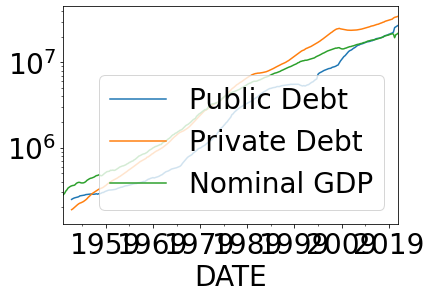

In [3]:
plt.rcParams.update({'font.size': 28})
data[["Public Debt", "Private Debt", "Nominal GDP"]].plot(logy = True)

<AxesSubplot:xlabel='DATE'>

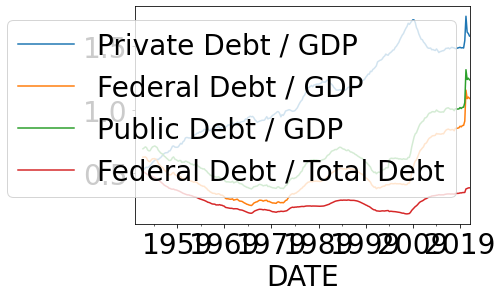

In [4]:
data[["Private Debt / GDP", "Federal Debt / GDP", "Public Debt / GDP", "Federal Debt / Total Debt"]].plot()


<ipython-input-5-2da99bee36d6>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(x)) + "%" for x in ax.get_yticks()])
<ipython-input-5-2da99bee36d6>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([str(int(x * 100)) + "%" for x in ax2.get_yticks()])


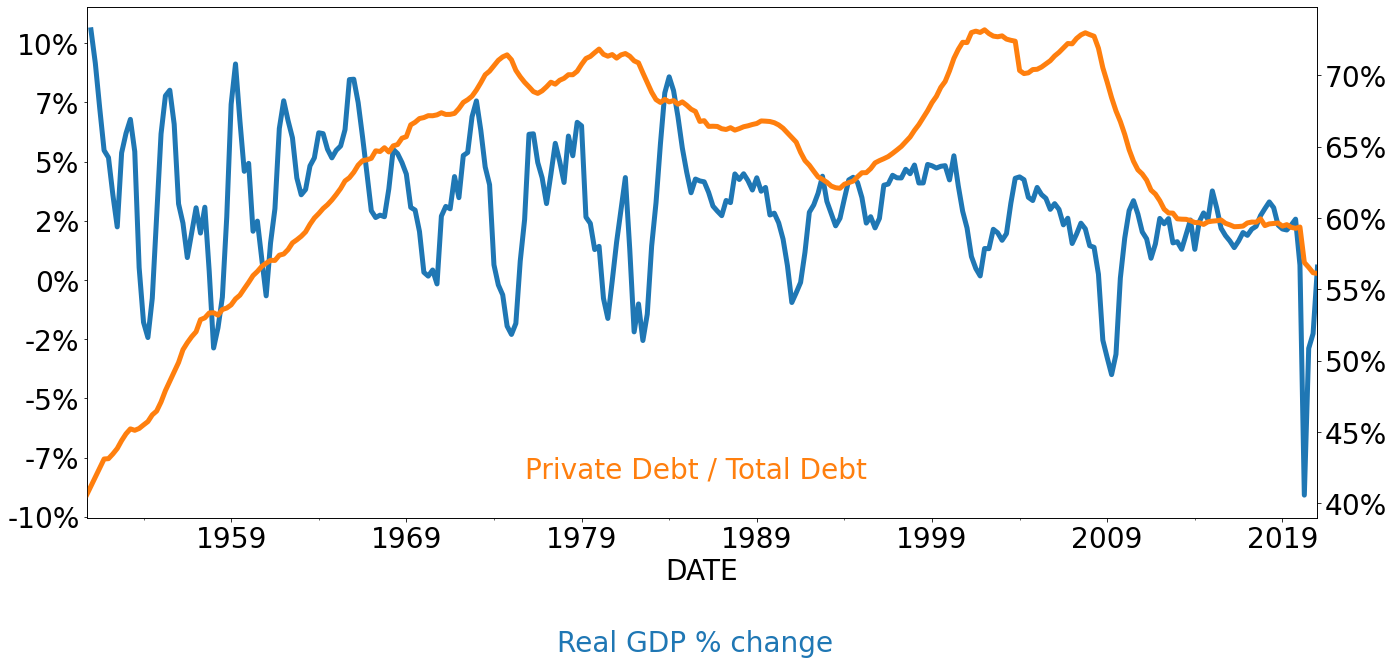

In [5]:
fig, ax = plt.subplots(figsize = (20,10))

ax2 = ax.twinx()
x = int(len(data) / 2)
NGDP_name =  "Real GDP % change"
debt_name = "Private Debt / Total Debt"
plt.text(data.index[x],data.iloc[x][NGDP_name]/ 14.4,NGDP_name, fontsize = 28,ha = "center", color = "C0")
plt.text(data.index[x],data.iloc[x][NGDP_name] / 10.2,debt_name, fontsize = 28,ha = "center", color = "C1")
data["Real GDP % change"].dropna().plot.line(linewidth = 5,
                                          ax = ax,
                                          legend = False)
data["Private Debt / Total Debt"].dropna().plot.line(linewidth = 5,
                                           ax = ax2,
                                           legend = False,
                                           color = "C1")
ax.set_yticklabels([str(int(x)) + "%" for x in ax.get_yticks()])
ax2.set_yticklabels([str(int(x * 100)) + "%" for x in ax2.get_yticks()])
plt.tight_layout()

<AxesSubplot:xlabel='Aaa Rate diff', ylabel='Federal Funds Rate diff'>

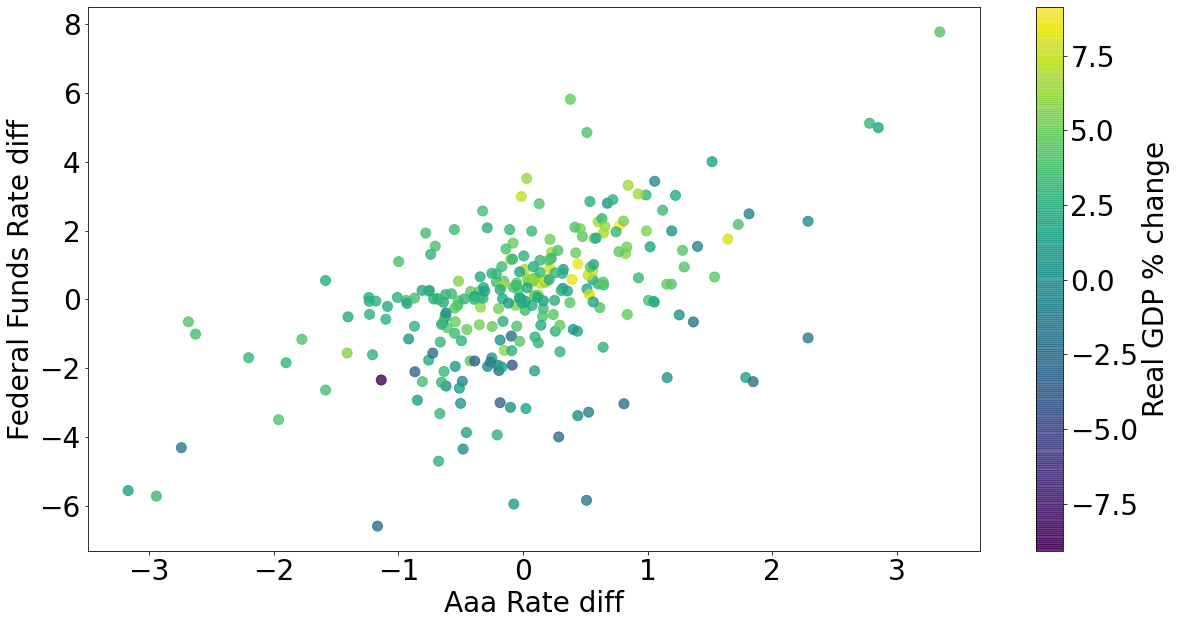

In [6]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(x = "Aaa Rate diff", 
                  y = "Federal Funds Rate diff", 
                  c = "Real GDP % change", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")

<AxesSubplot:xlabel='Private Debt / Total Debt diff', ylabel='Aaa and Federal Funds Rate Spread diff'>

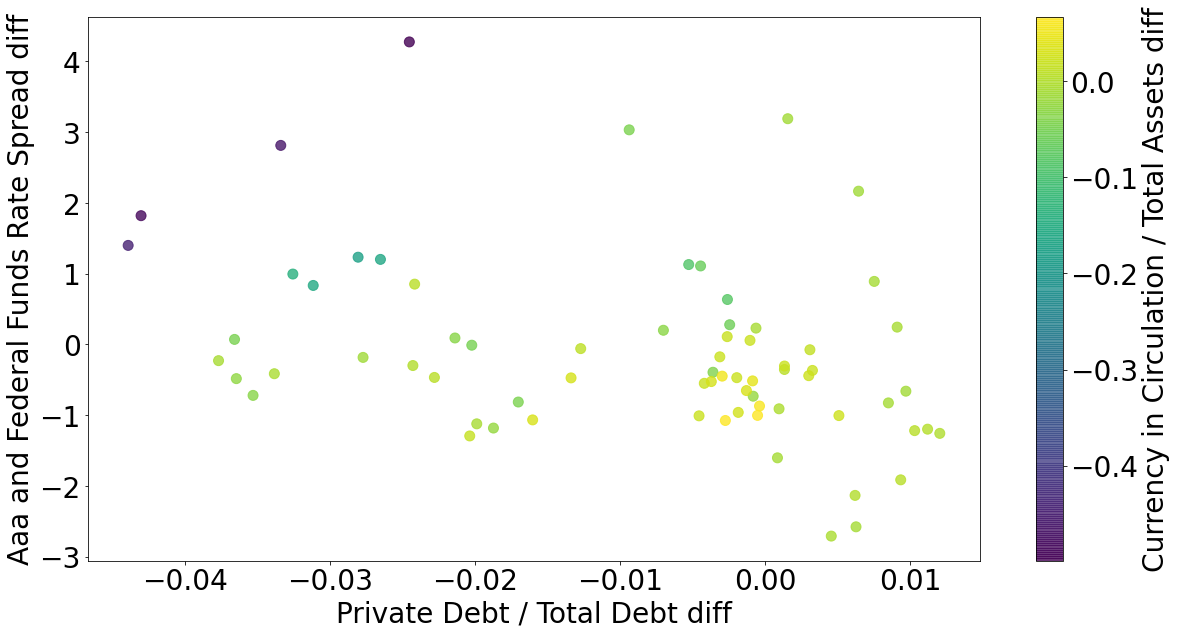

In [7]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(x = "Private Debt / Total Debt diff", 
                  y = "Aaa and Federal Funds Rate Spread diff", 
                  c = "Currency in Circulation / Total Assets diff", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")

<AxesSubplot:xlabel='Aaa and Federal Funds Rate Spread diff', ylabel='Real GDP % change'>

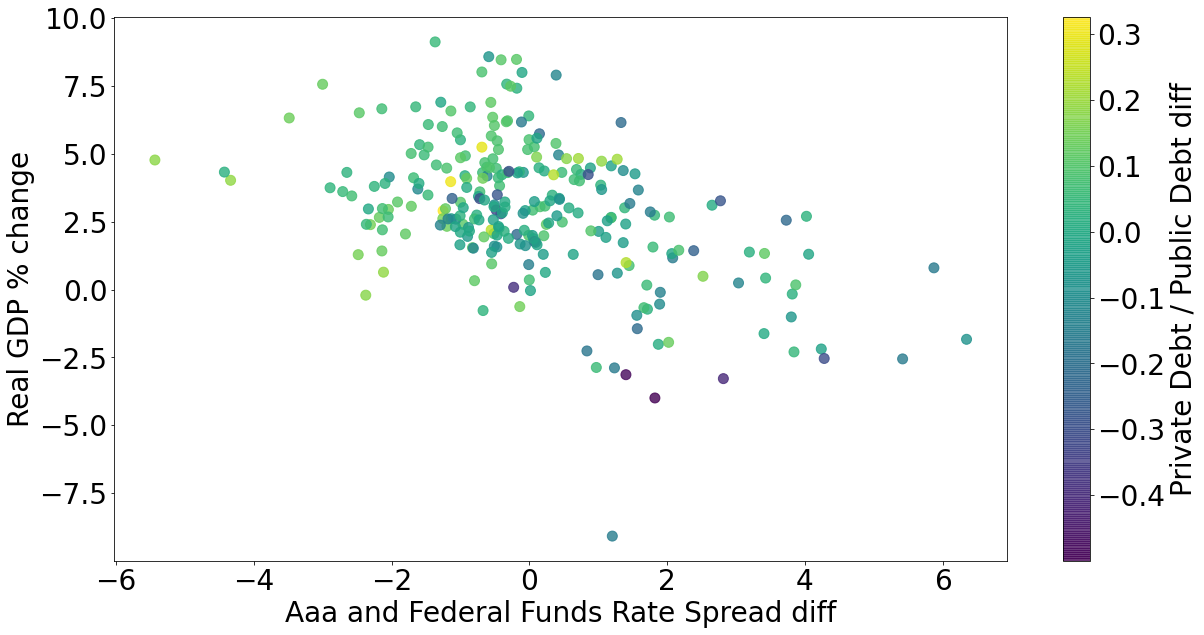

In [8]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(y = "Real GDP % change", 
                  x = "Aaa and Federal Funds Rate Spread diff", 
                  c = "Private Debt / Public Debt diff", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")


<AxesSubplot:xlabel='Private Debt / Public Debt diff', ylabel='Nominal GDP % change'>

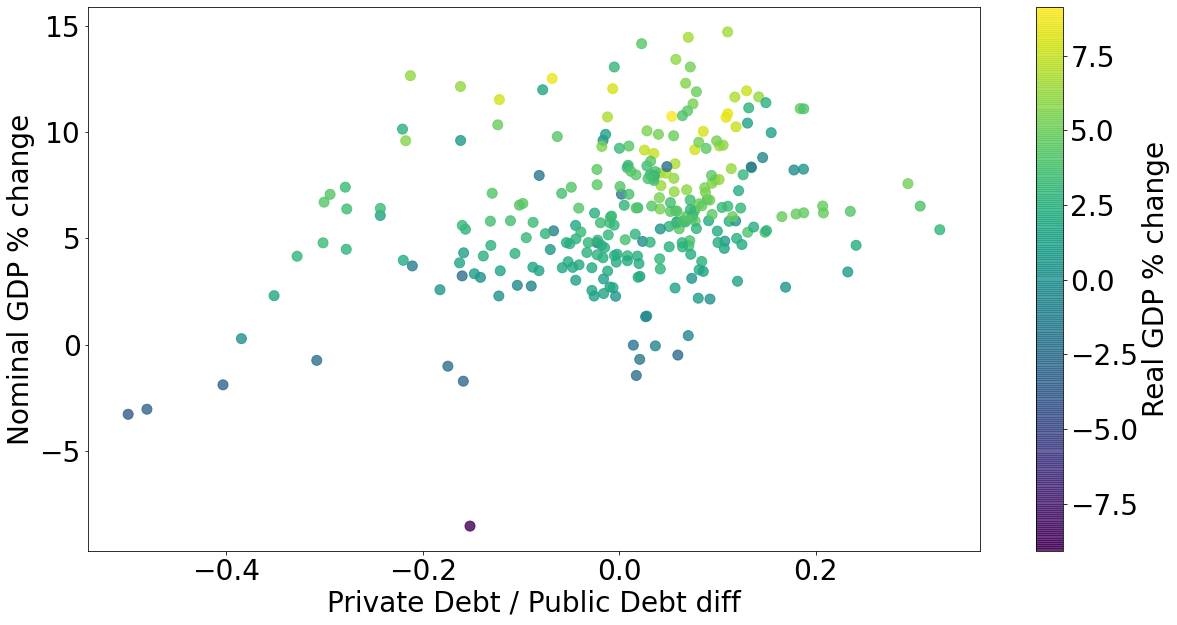

In [9]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(y = "Nominal GDP % change", 
                  x = "Private Debt / Public Debt diff",
                  c = "Real GDP % change", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")


<AxesSubplot:xlabel='Currency in Circulation / Total Assets diff', ylabel='Aaa and Federal Funds Rate Spread diff'>

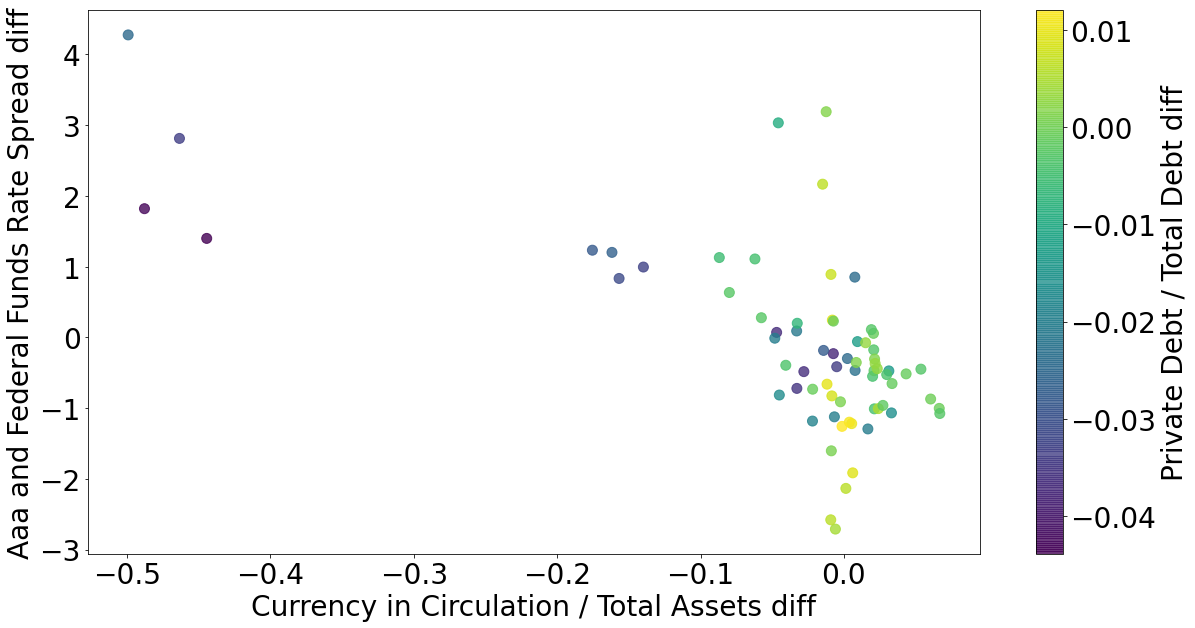

In [10]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(x = "Currency in Circulation / Total Assets diff", 
                  y = "Aaa and Federal Funds Rate Spread diff", 
                  c = "Private Debt / Total Debt diff", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")

<AxesSubplot:xlabel='Federal Funds Rate diff', ylabel='Aaa and Federal Funds Rate Spread diff'>

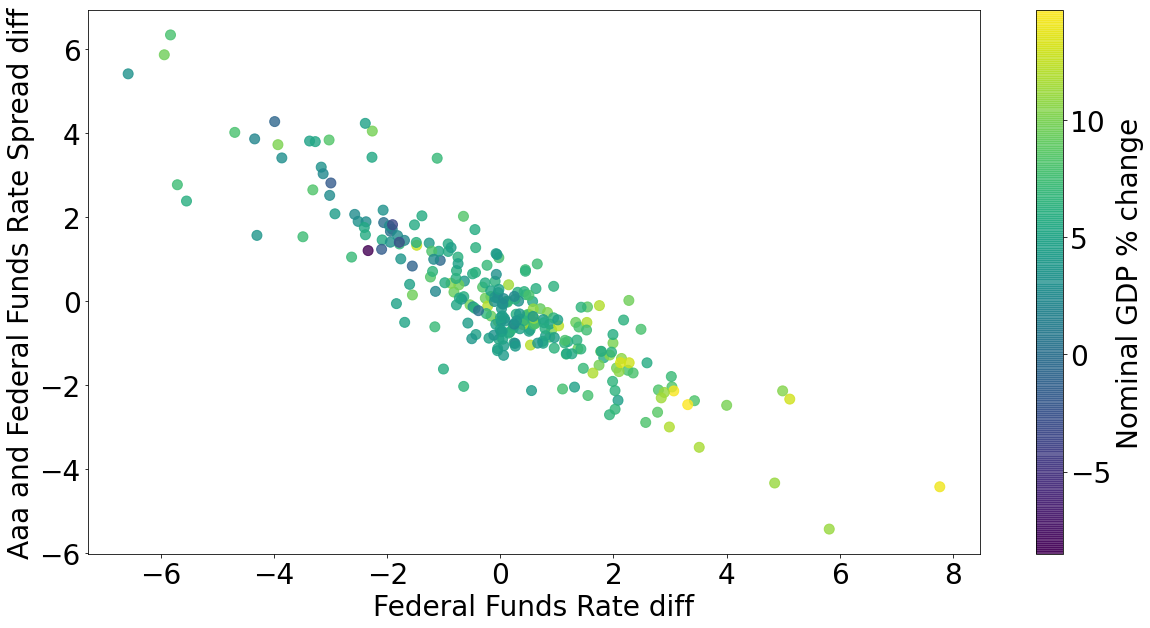

In [11]:
fig, ax = plt.subplots(figsize = (20,10))
data.plot.scatter(x = "Federal Funds Rate diff", 
                  y = "Aaa and Federal Funds Rate Spread diff", 
                  c = "Nominal GDP % change", 
                  s=100, 
                  alpha =.8,
                  ax = ax, 
                  colormap = "viridis")

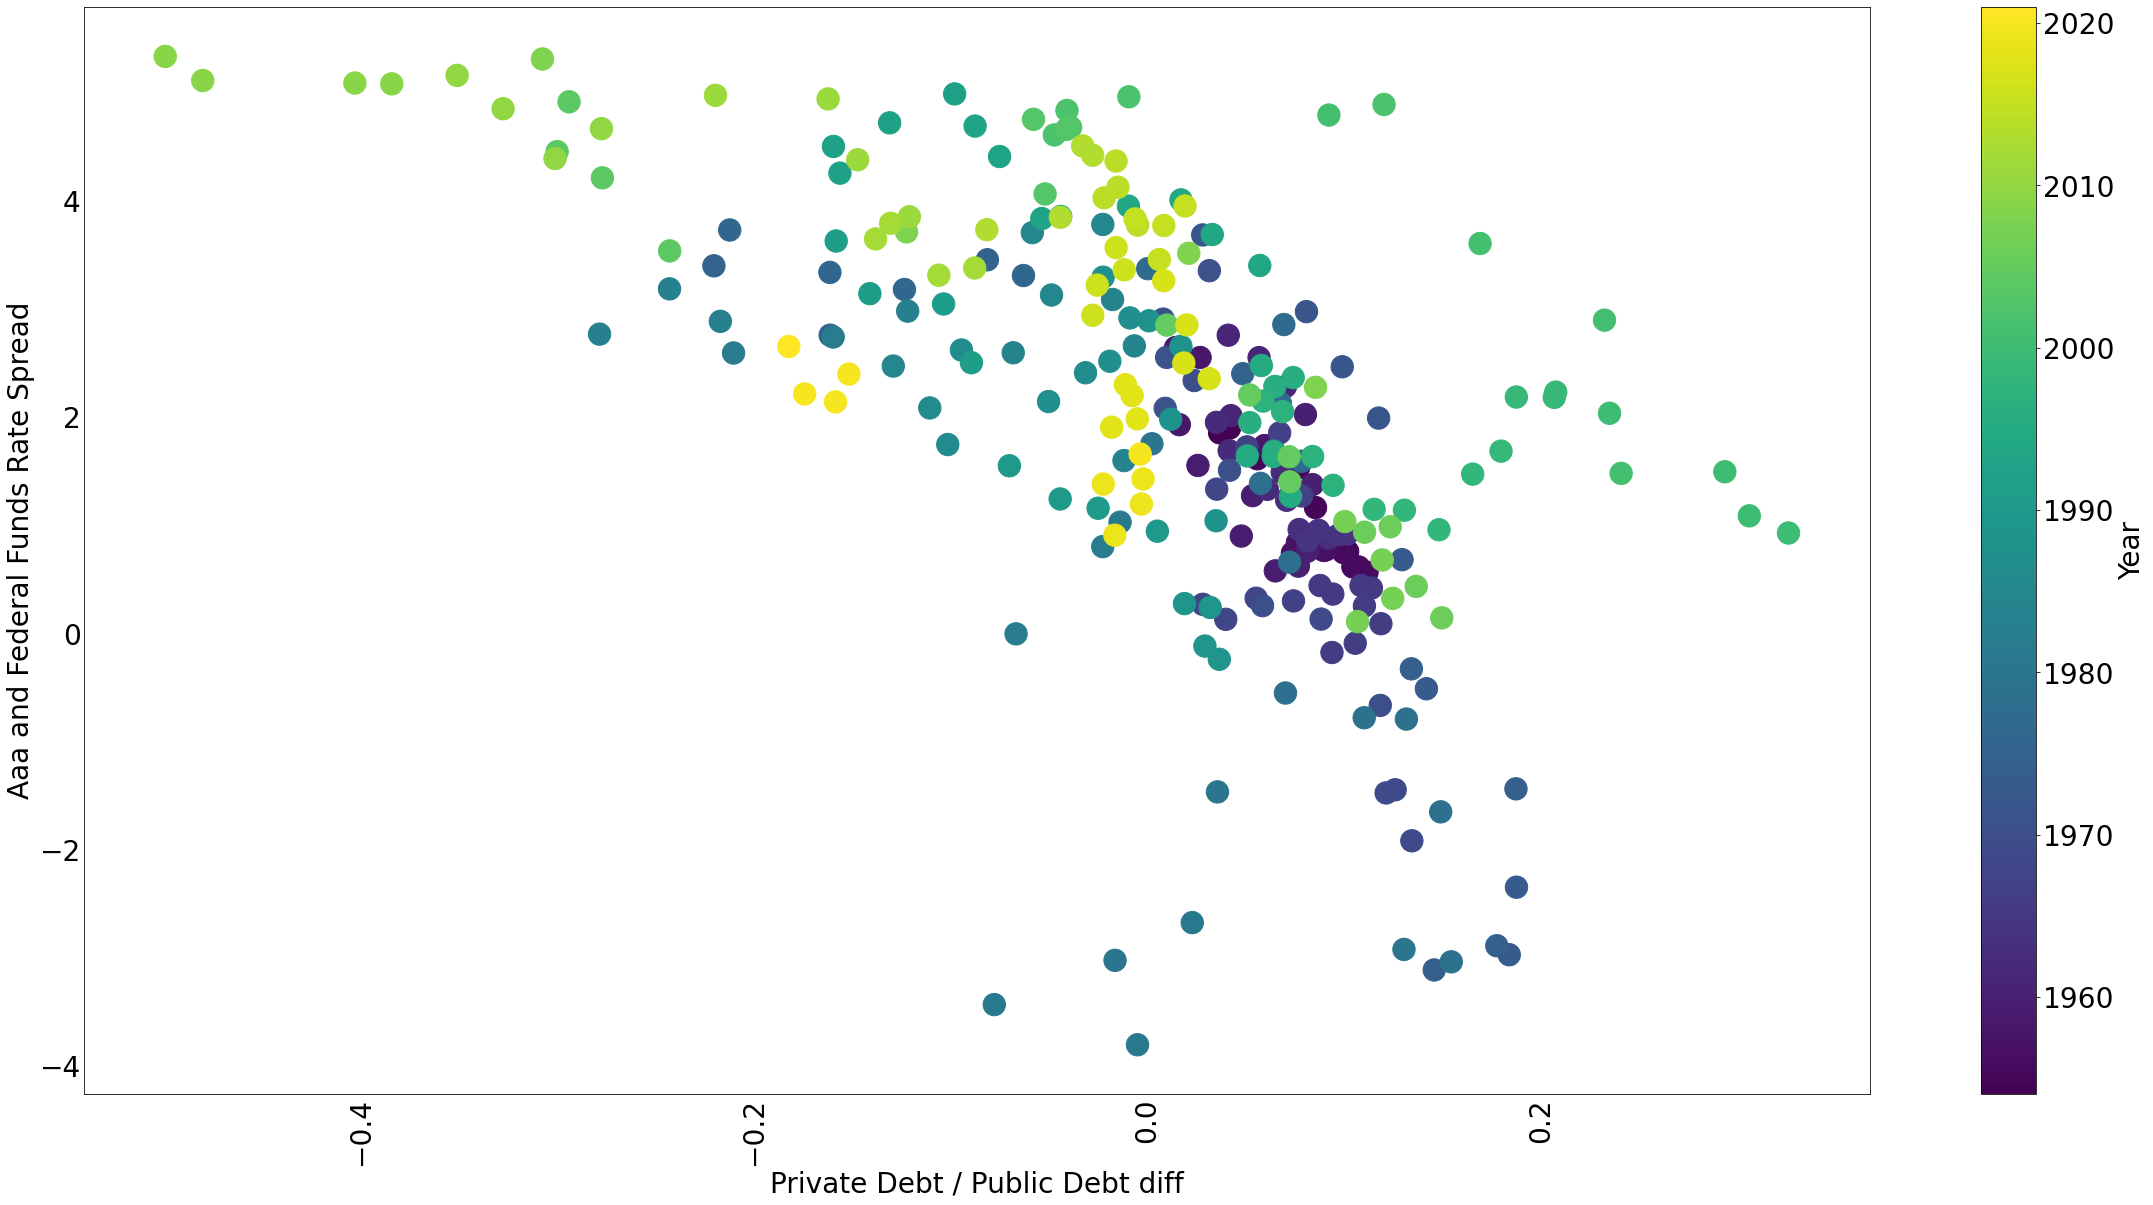

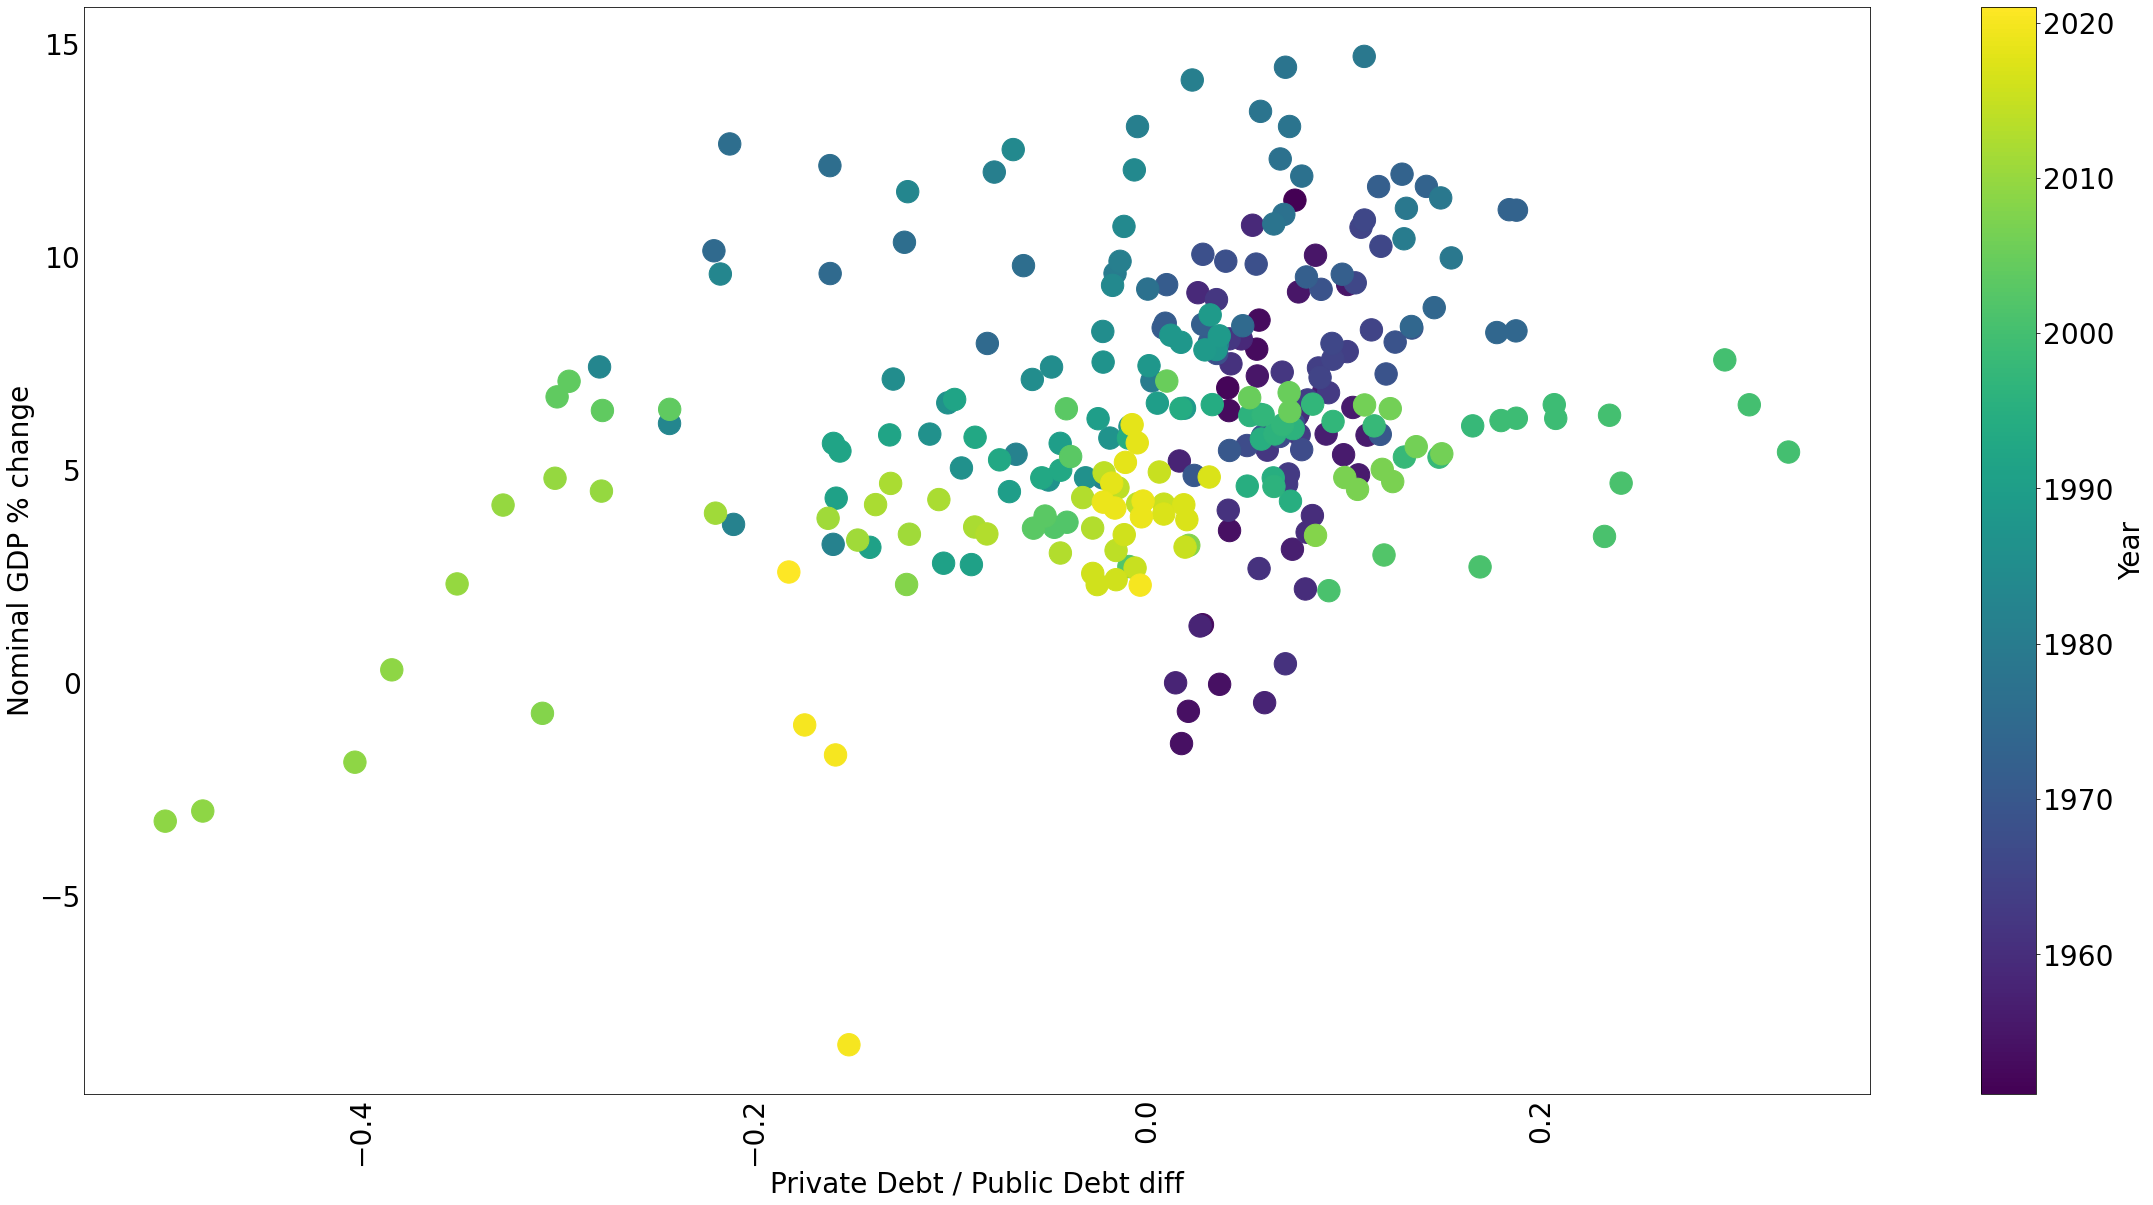

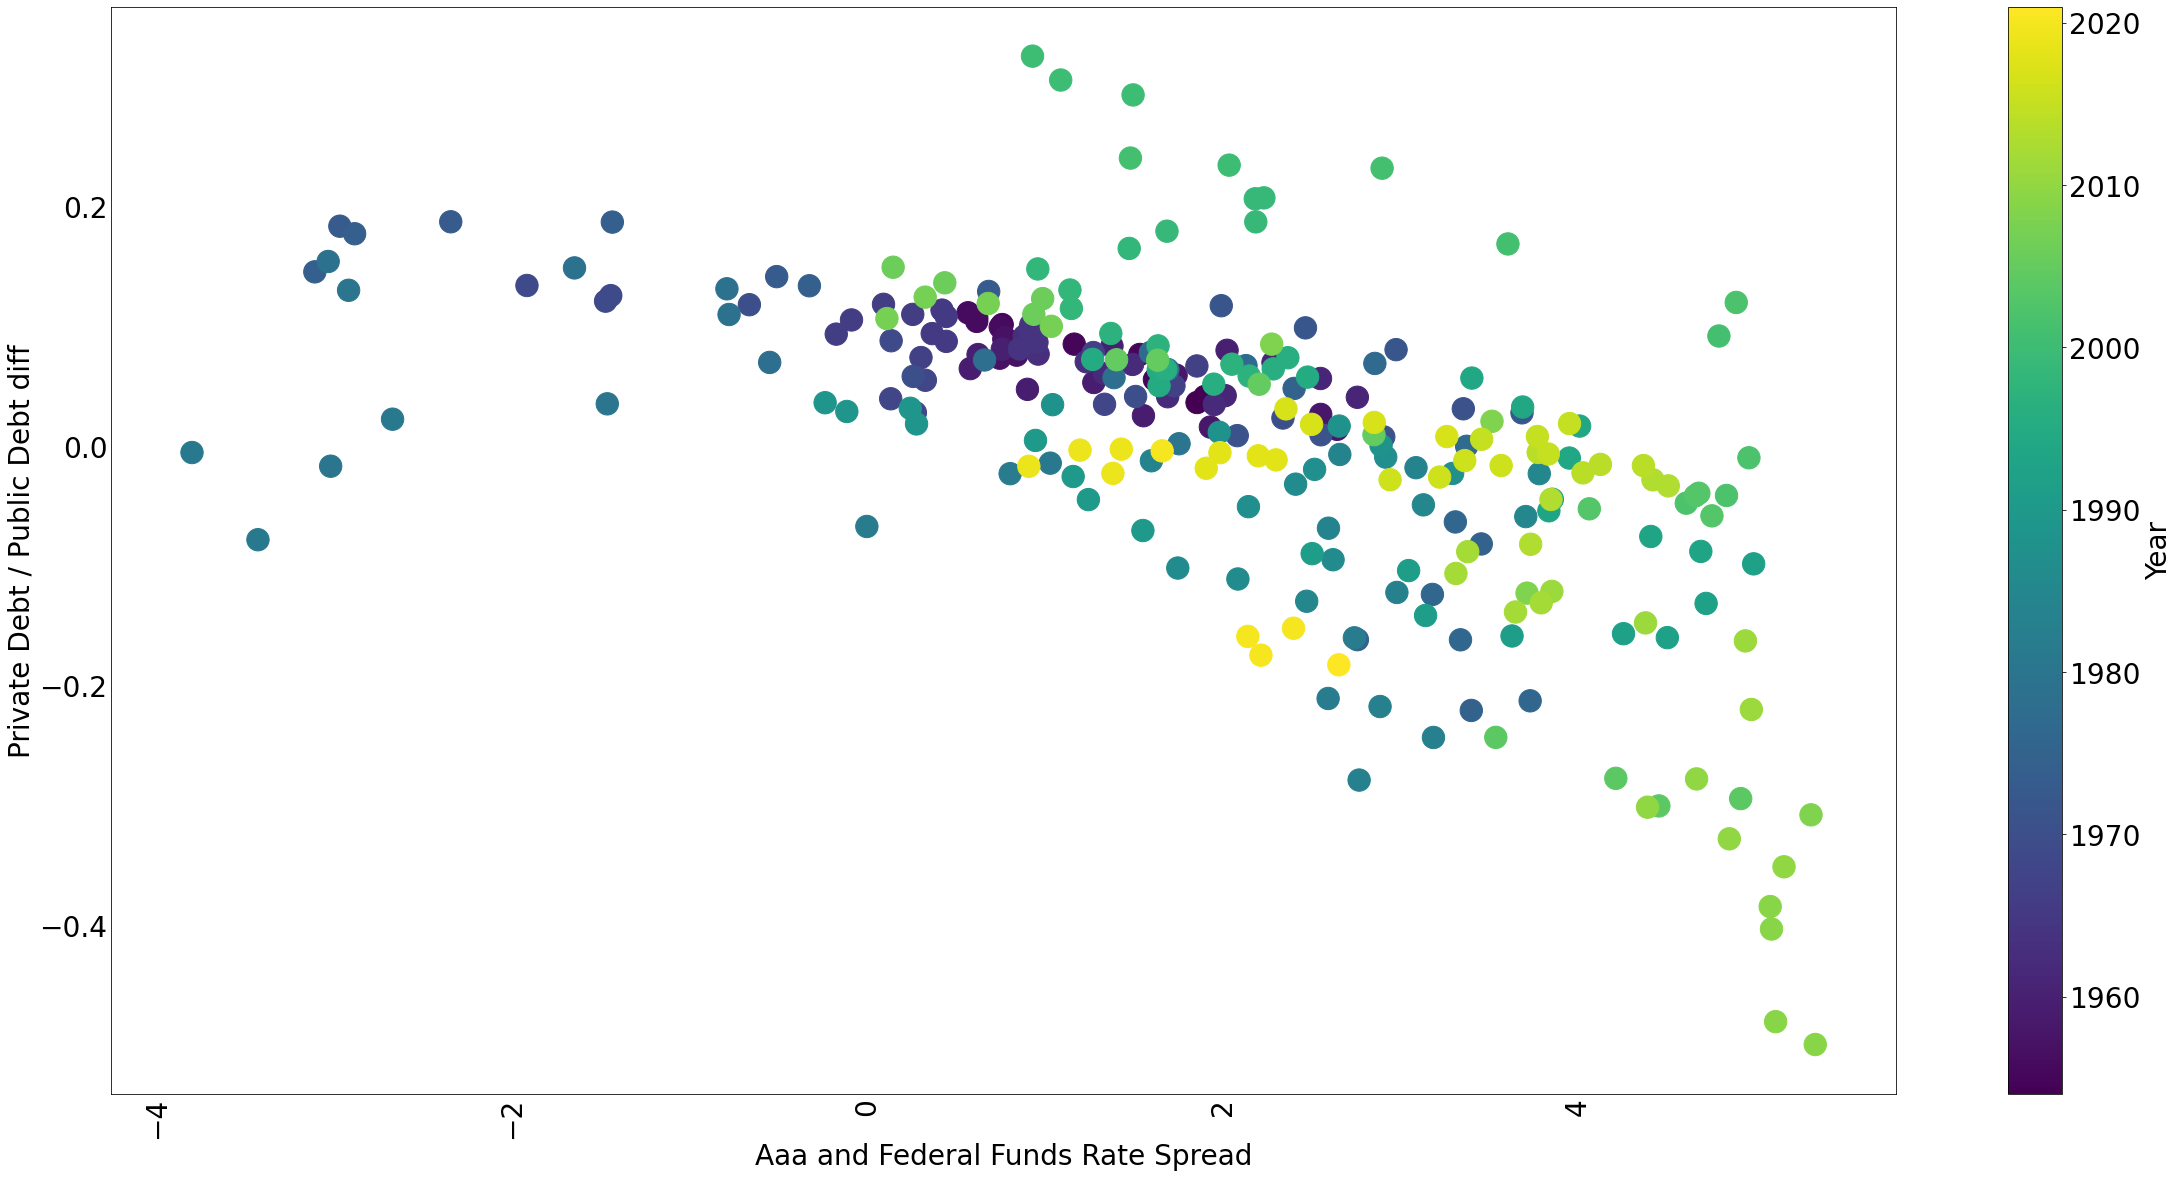

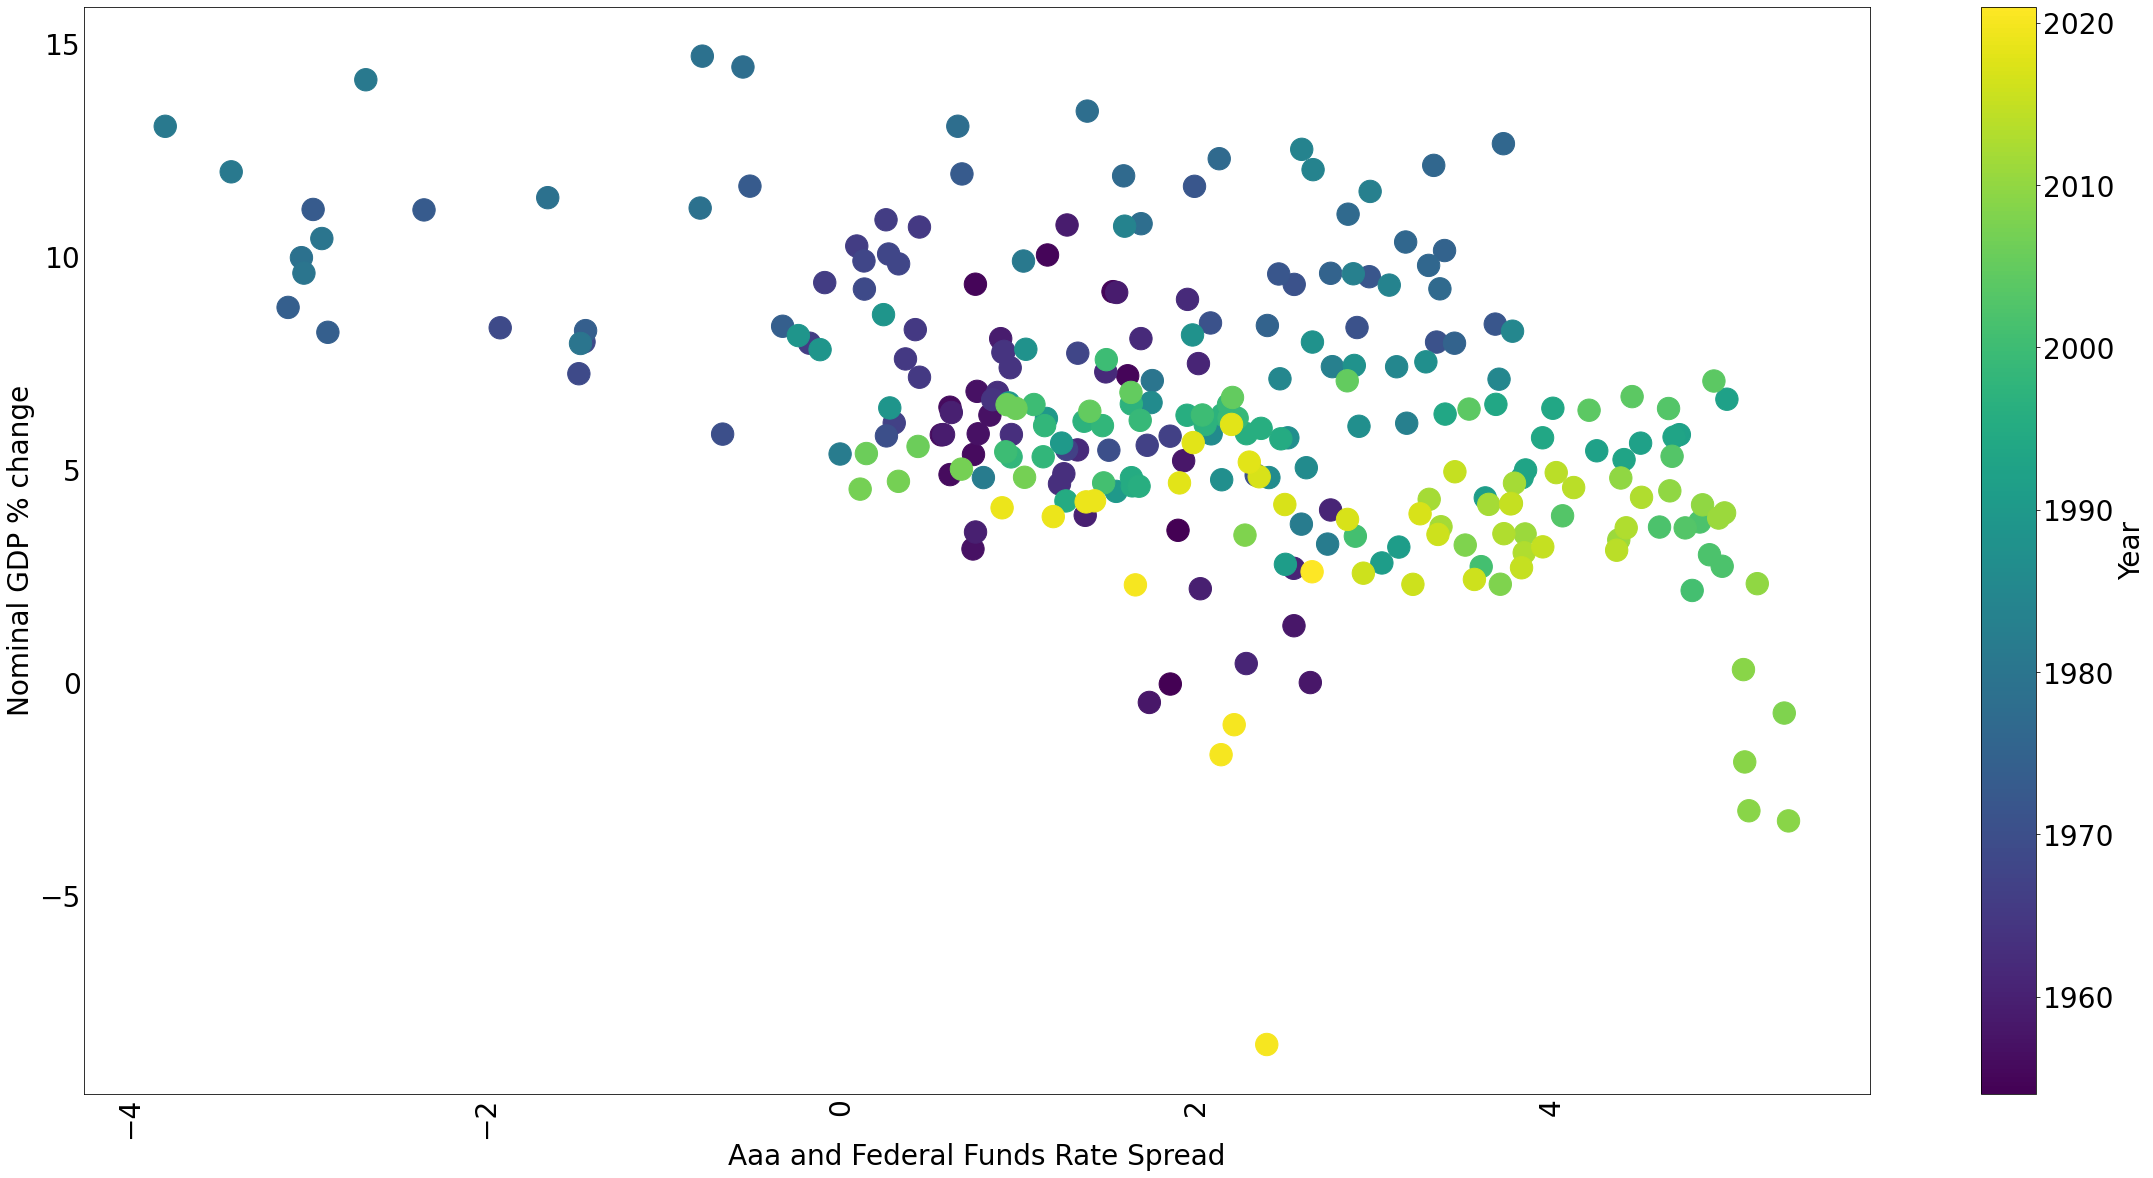

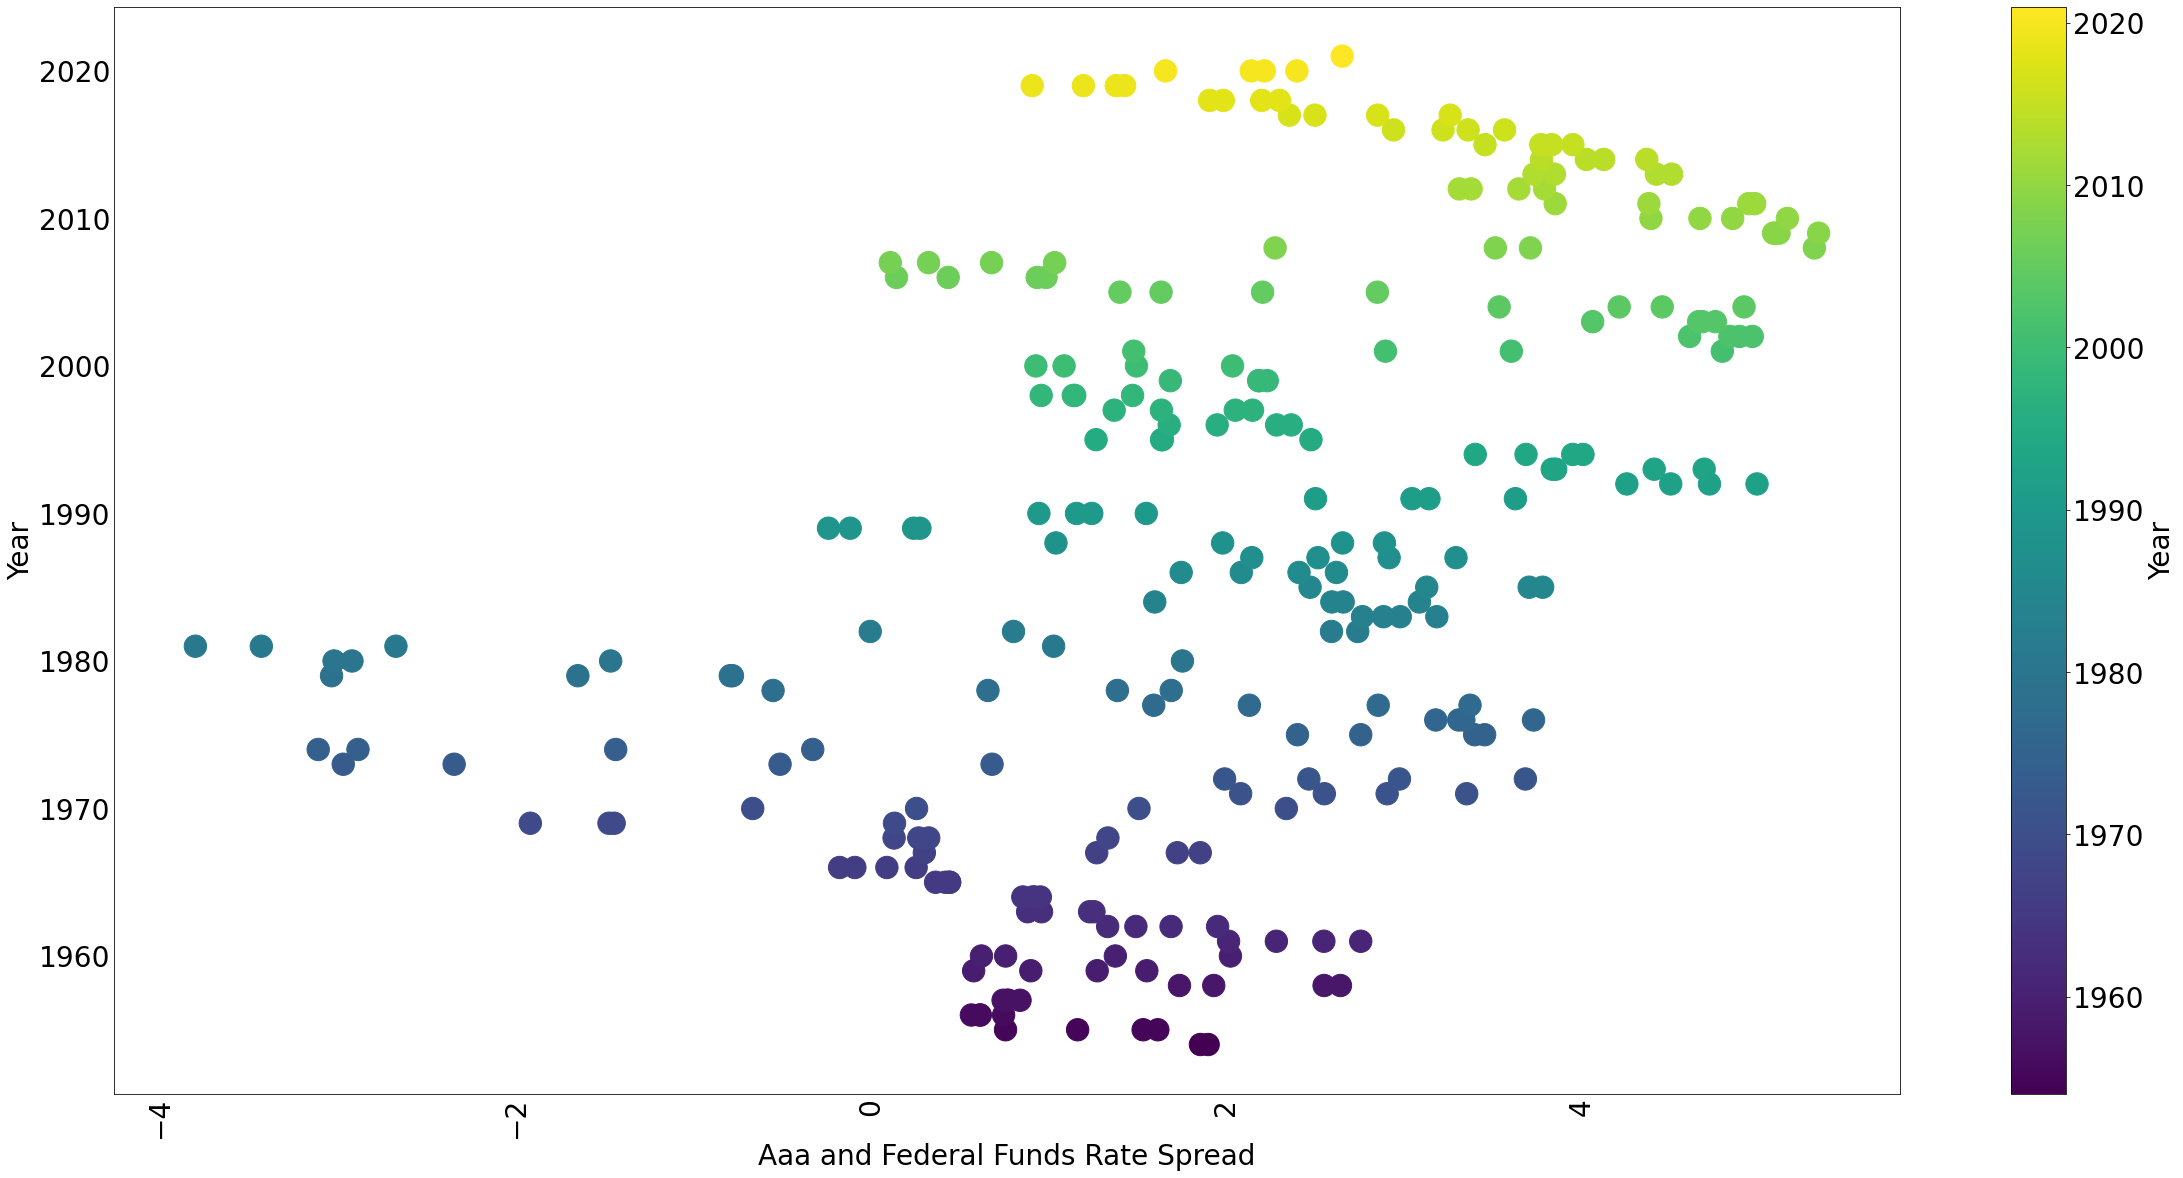

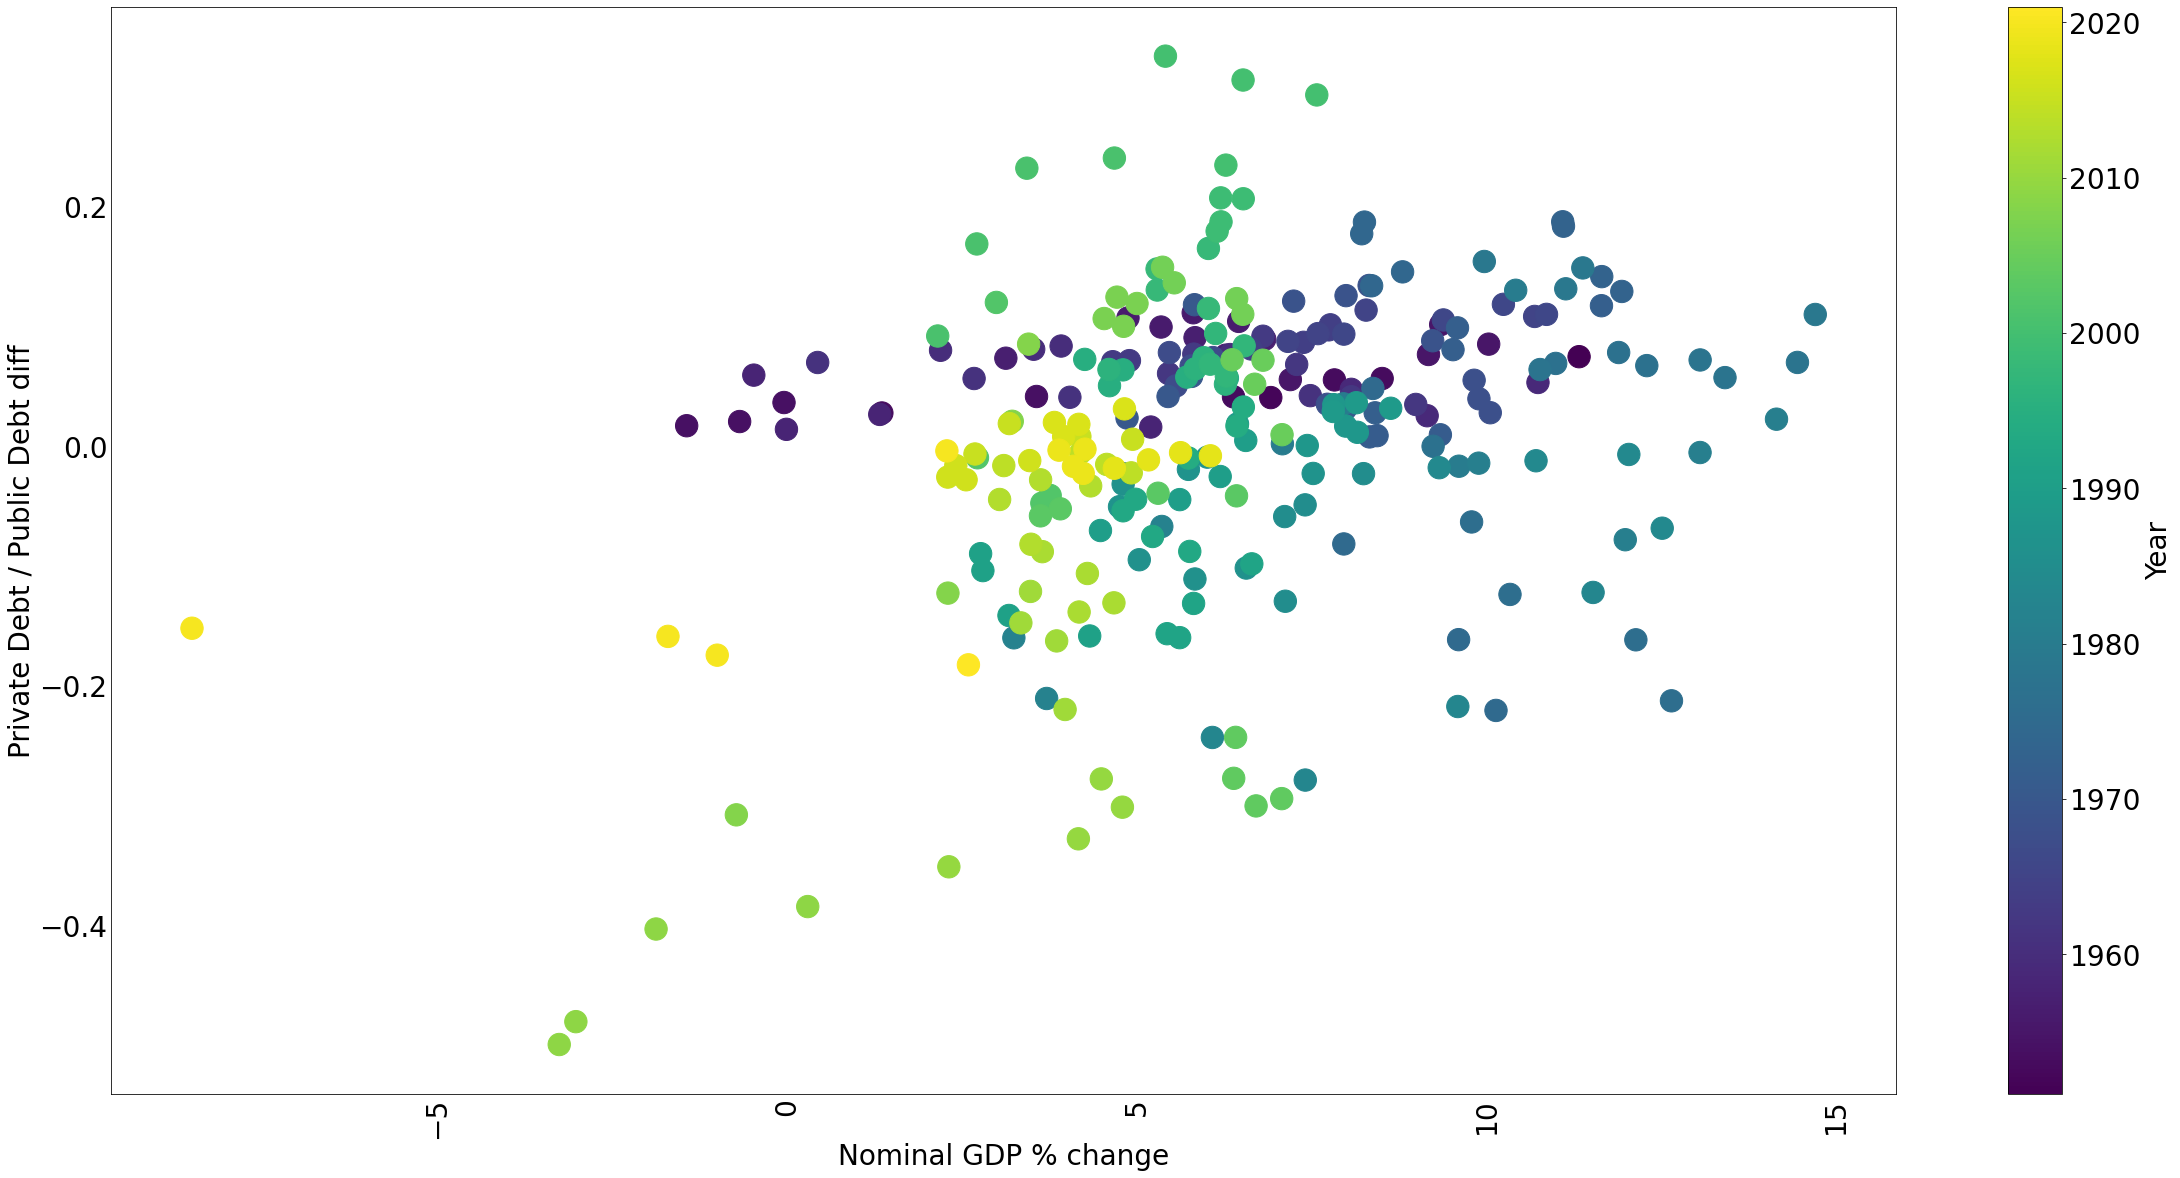

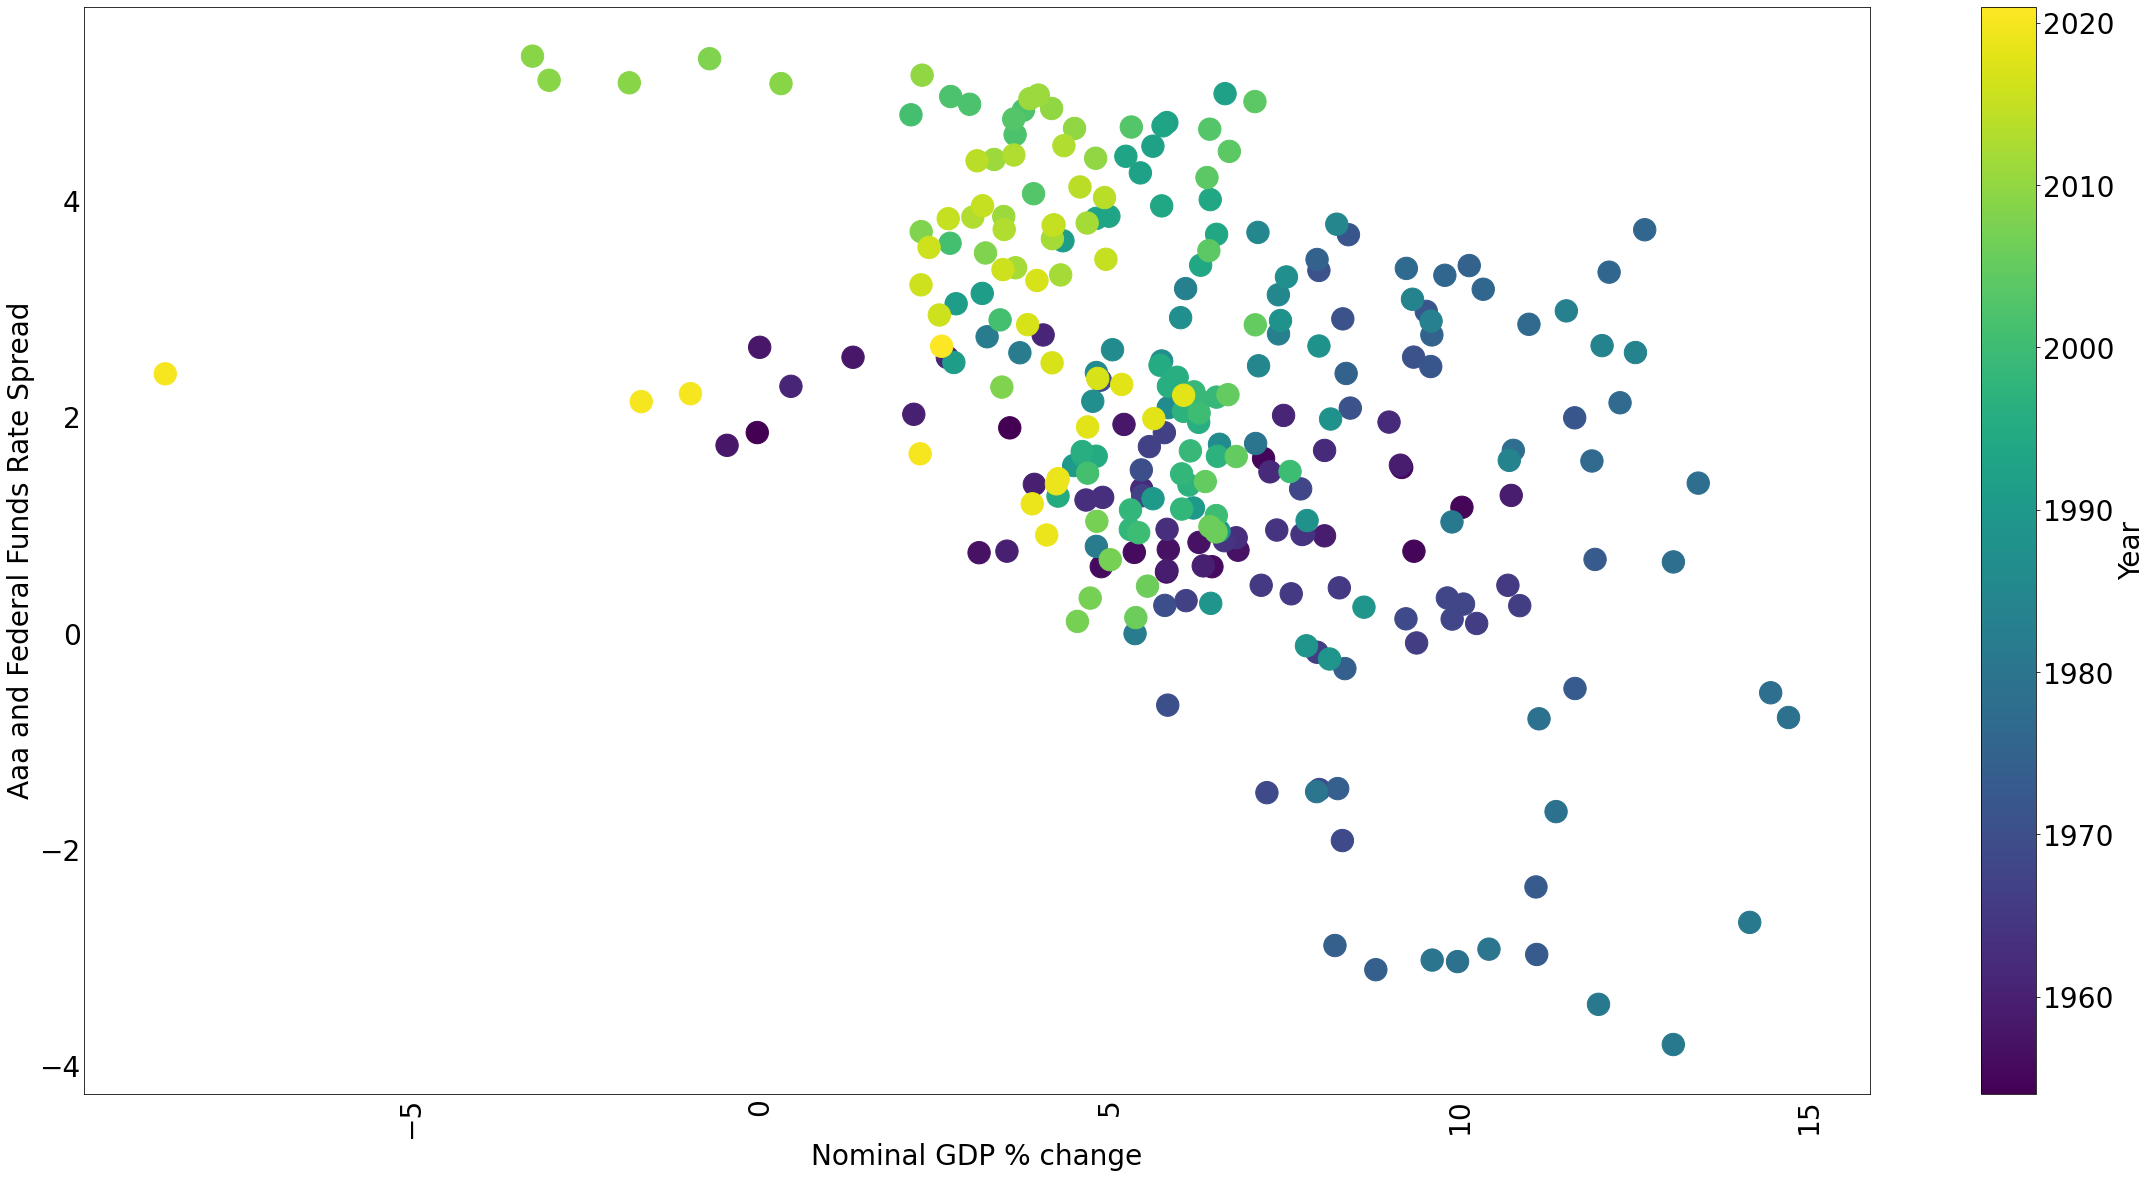

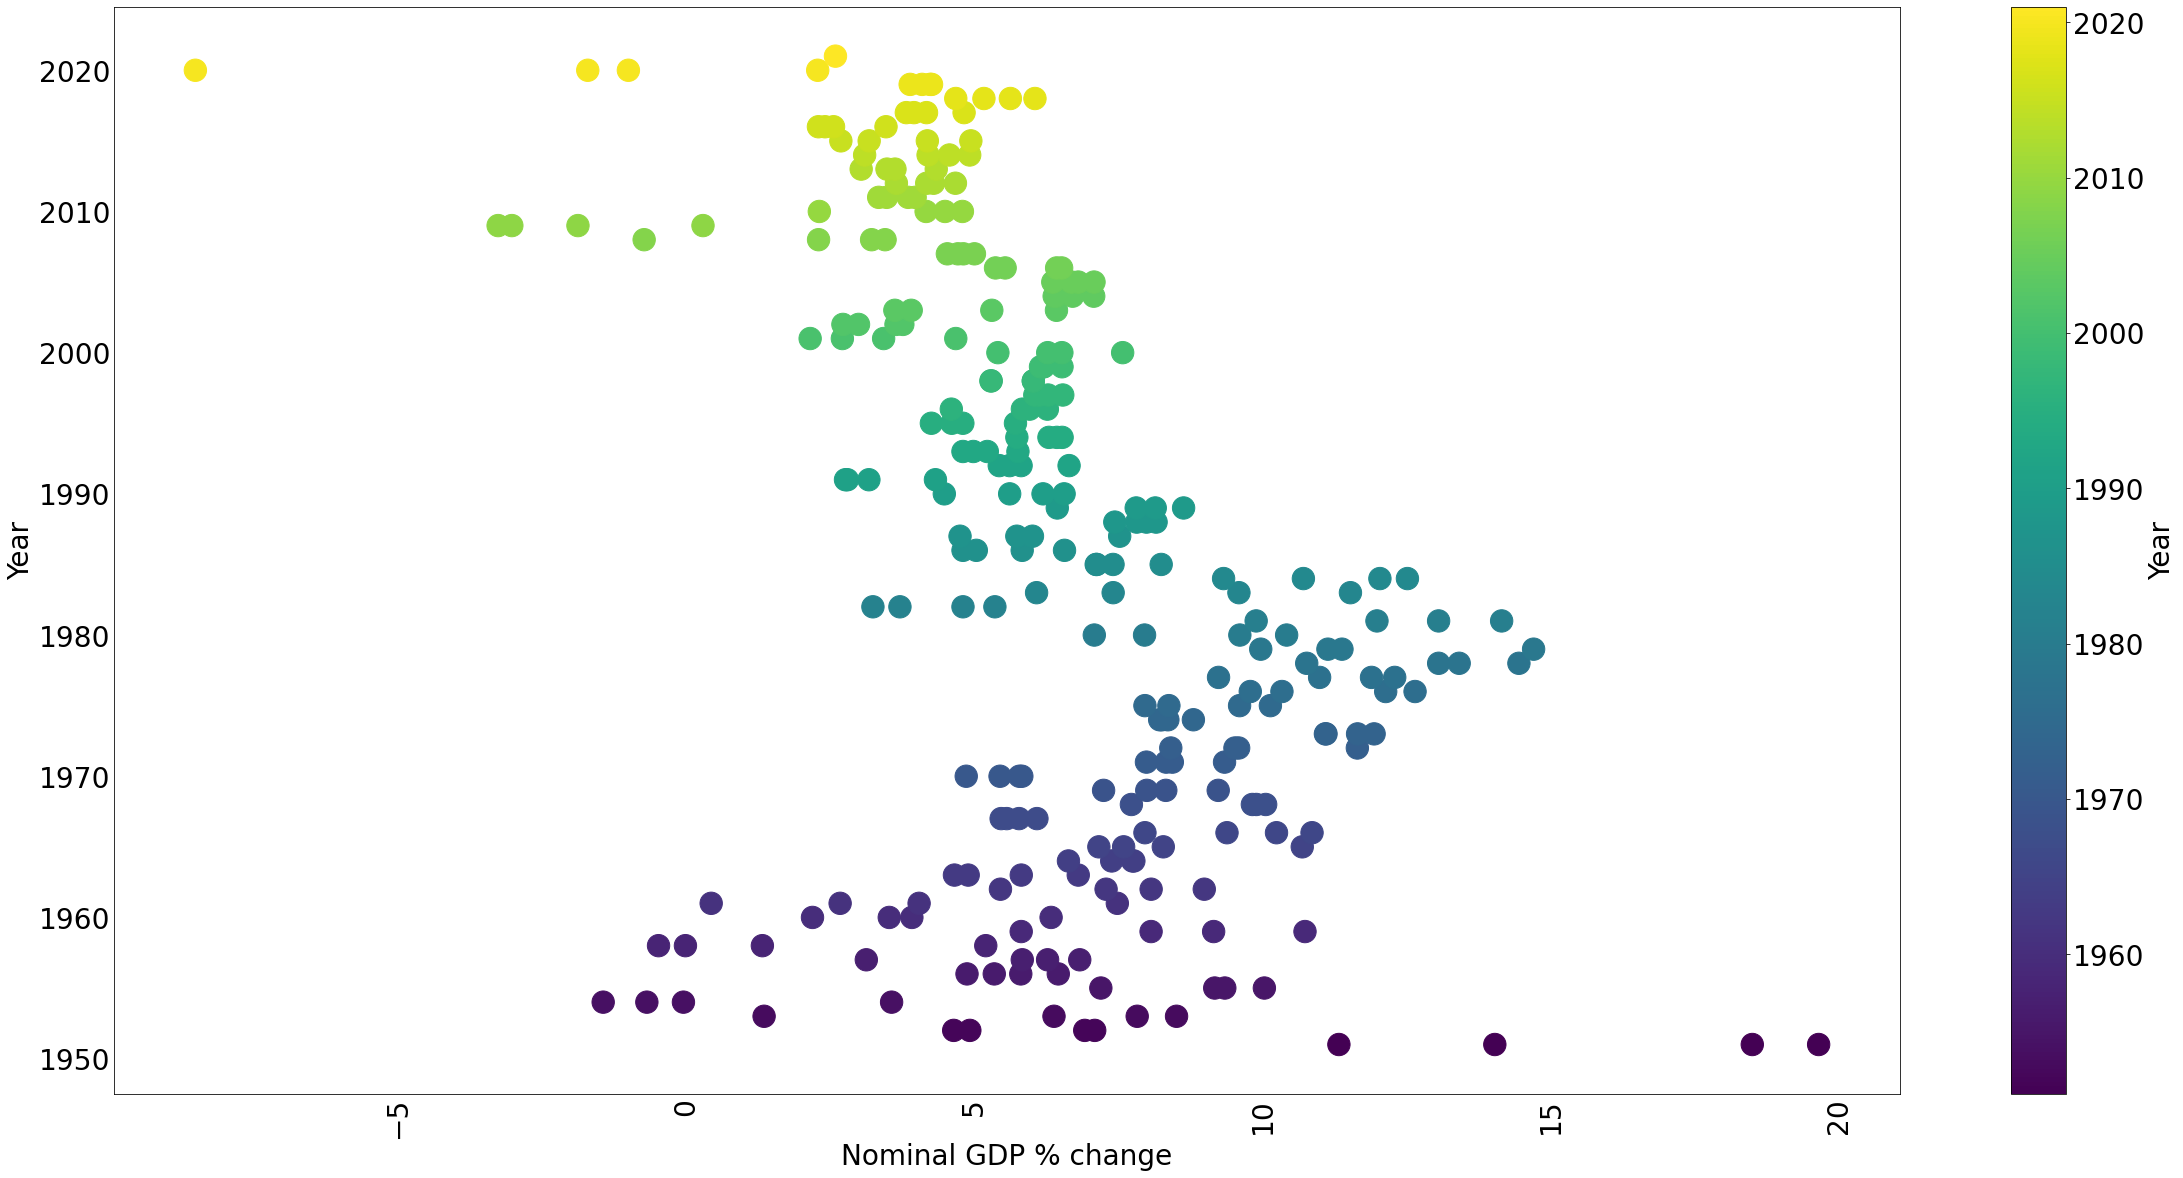

In [12]:
plot_scatter(data[["Private Debt / Public Debt diff",
                   "Aaa and Federal Funds Rate Spread",
                   "Nominal GDP % change"]], s = 500)

In [13]:
data[["Nominal GDP % change", "Private Debt / Public Debt"]].corr()

,Nominal GDP % change,Private Debt / Public Debt
Nominal GDP % change,1.00000,0.27876
Private Debt / Public Debt,0.27876,1.00000


In [14]:
# set default fontsize for text in plot
plt.rcParams.update({'font.size': 24})
plt.rcParams['axes.ymargin'] = .05
plt.rcParams['axes.xmargin'] = .05

In [15]:
import pingouin
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.patches import Rectangle
from pgmpy.estimators import PC
from pgmpy.base import DAG
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
import networkx as nx
plt.rcParams.update({"font.size":20})

def graph_DAG(edges, df, title = ""):
    pcorr = df.pcorr()
    graph = nx.DiGraph()
    edge_labels = {}
    for edge in edges:
        edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))
        
    graph.add_edges_from(edges)
    color_map = ["C7" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph, k = 5/(len(edge_labels.keys())**.5))

    plt.title(title, fontsize = 30)
    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 1200,
                     with_labels=True,  arrows=True,
                     #font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"), ax = ax)
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    
def calculate_pcorr(data, keys):
    pcorr_df = data[keys]

    pcorr_dct = {}
    p_val_dct = {}
    for key1 in keys:
        p_val_dct[key1] = {}
        pcorr_dct[key1] = {}
        for key2 in keys:
            if key1 != key2:
                other_vars = [z for z in pcorr_df.keys() if z != key1 and z != key2 ]
                stats = pingouin.partial_corr(data=pcorr_df, 
                                              x = key1, 
                                              y = key2, 
                                              covars=other_vars)
                p_val_dct[key1][key2] = stats["p-val"].values[0]

                pcorr_dct[key1][key2] = pcorr_df.pcorr()[key1][key2]
            else:
                p_val_dct[key1][key2] = 1
                pcorr_dct[key1][key2] = 1

    p_val_df = pd.DataFrame(p_val_dct)
    pcorr_df = pd.DataFrame(pcorr_dct)
    return pcorr_df, p_val_df


Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  7.10it/s]C:\Users\JLCat\anaconda3\lib\site-packages\pgmpy\estimators\PC.py:369: UserWarning: Reached maximum number of allowed conditional variables. Exiting
  warn("Reached maximum number of allowed conditional variables. Exiting")
Working for n conditional variables: 2: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  5.82it/s]


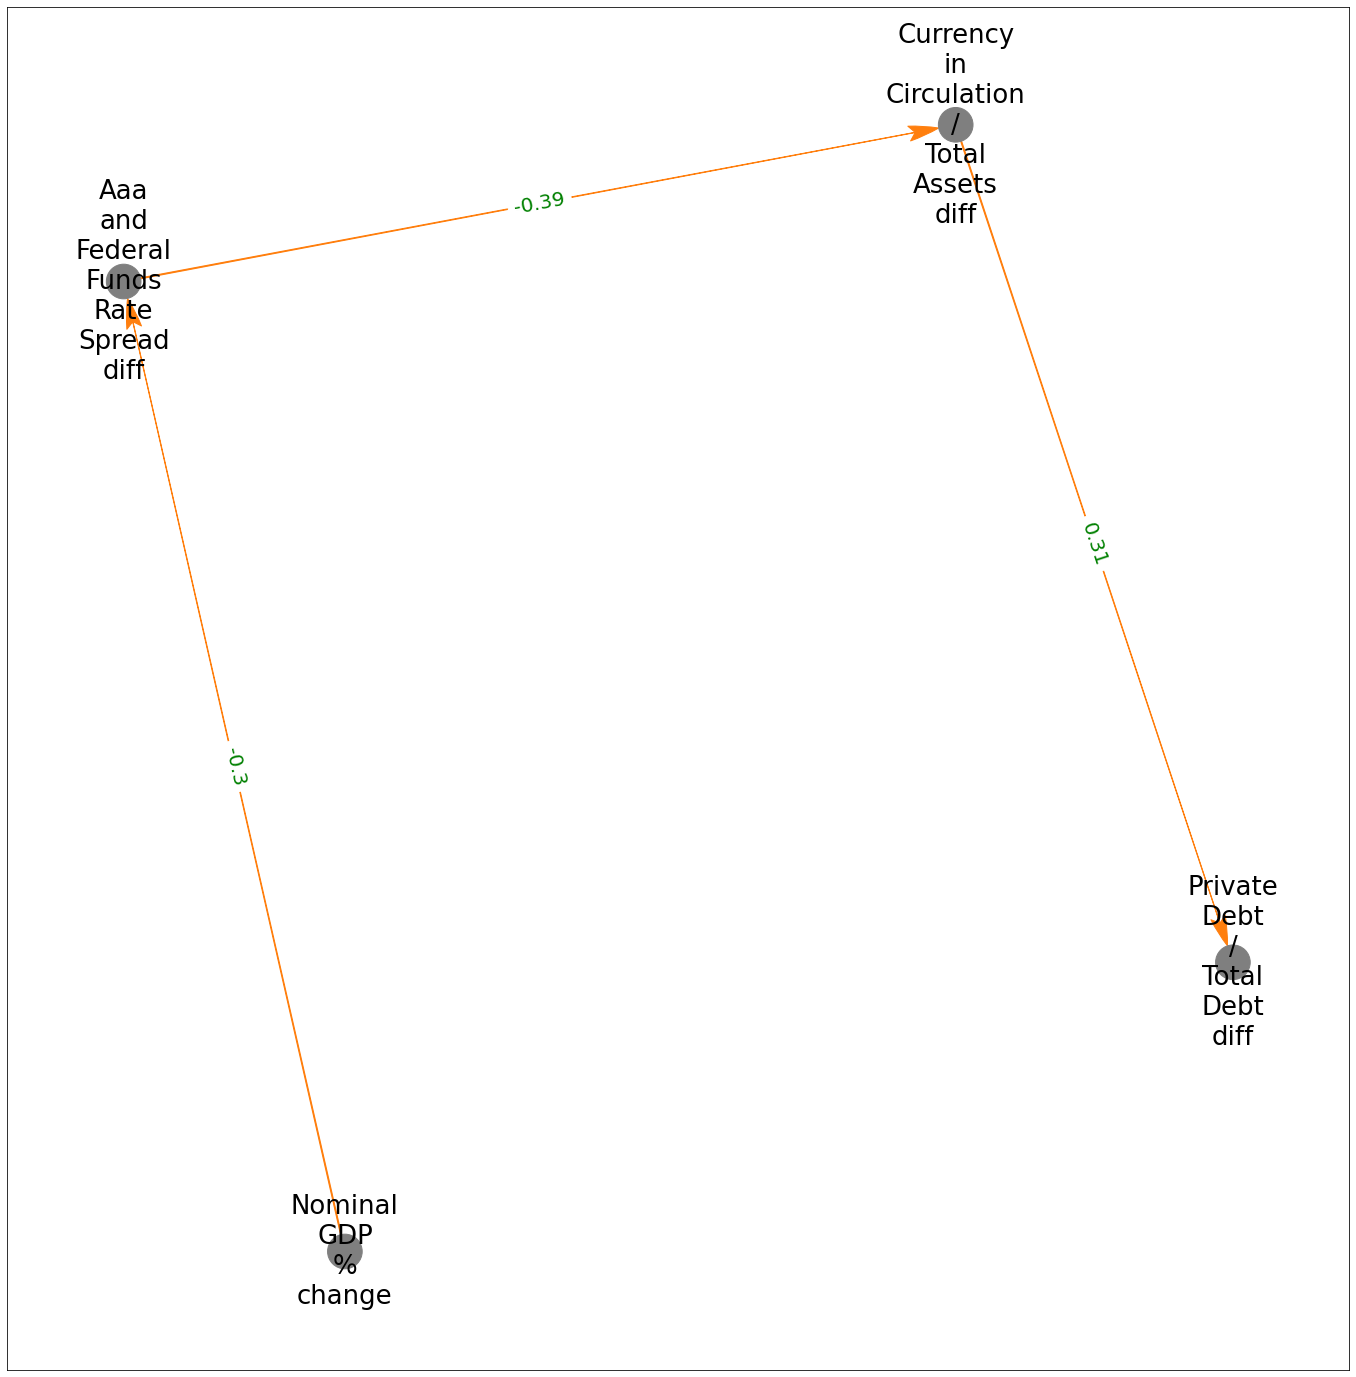

In [16]:
keys = ["Private Debt / Total Debt diff",
        "Nominal GDP % change",
        #"Nominal GDP % change year-over-year",
        "Aaa and Federal Funds Rate Spread diff",
#         "Federal Funds Rate diff year-over-year",
        "Currency in Circulation / Total Assets diff"]
pcorr_df, p_val_df = calculate_pcorr(data, keys)
dag_df = data[keys]
dag_df = dag_df.dropna().rename(
    columns={
        col:col.replace(" ", "\n") for col in keys})
variant = "parallel"
sig = 0.05
ci_test = "pearsonr"
c = PC(dag_df)
max_cond_vars = len(keys) - 2
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)
edges = model.edges()
graph_DAG(edges, dag_df)  

Working for n conditional variables: 3: 100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  8.57it/s]


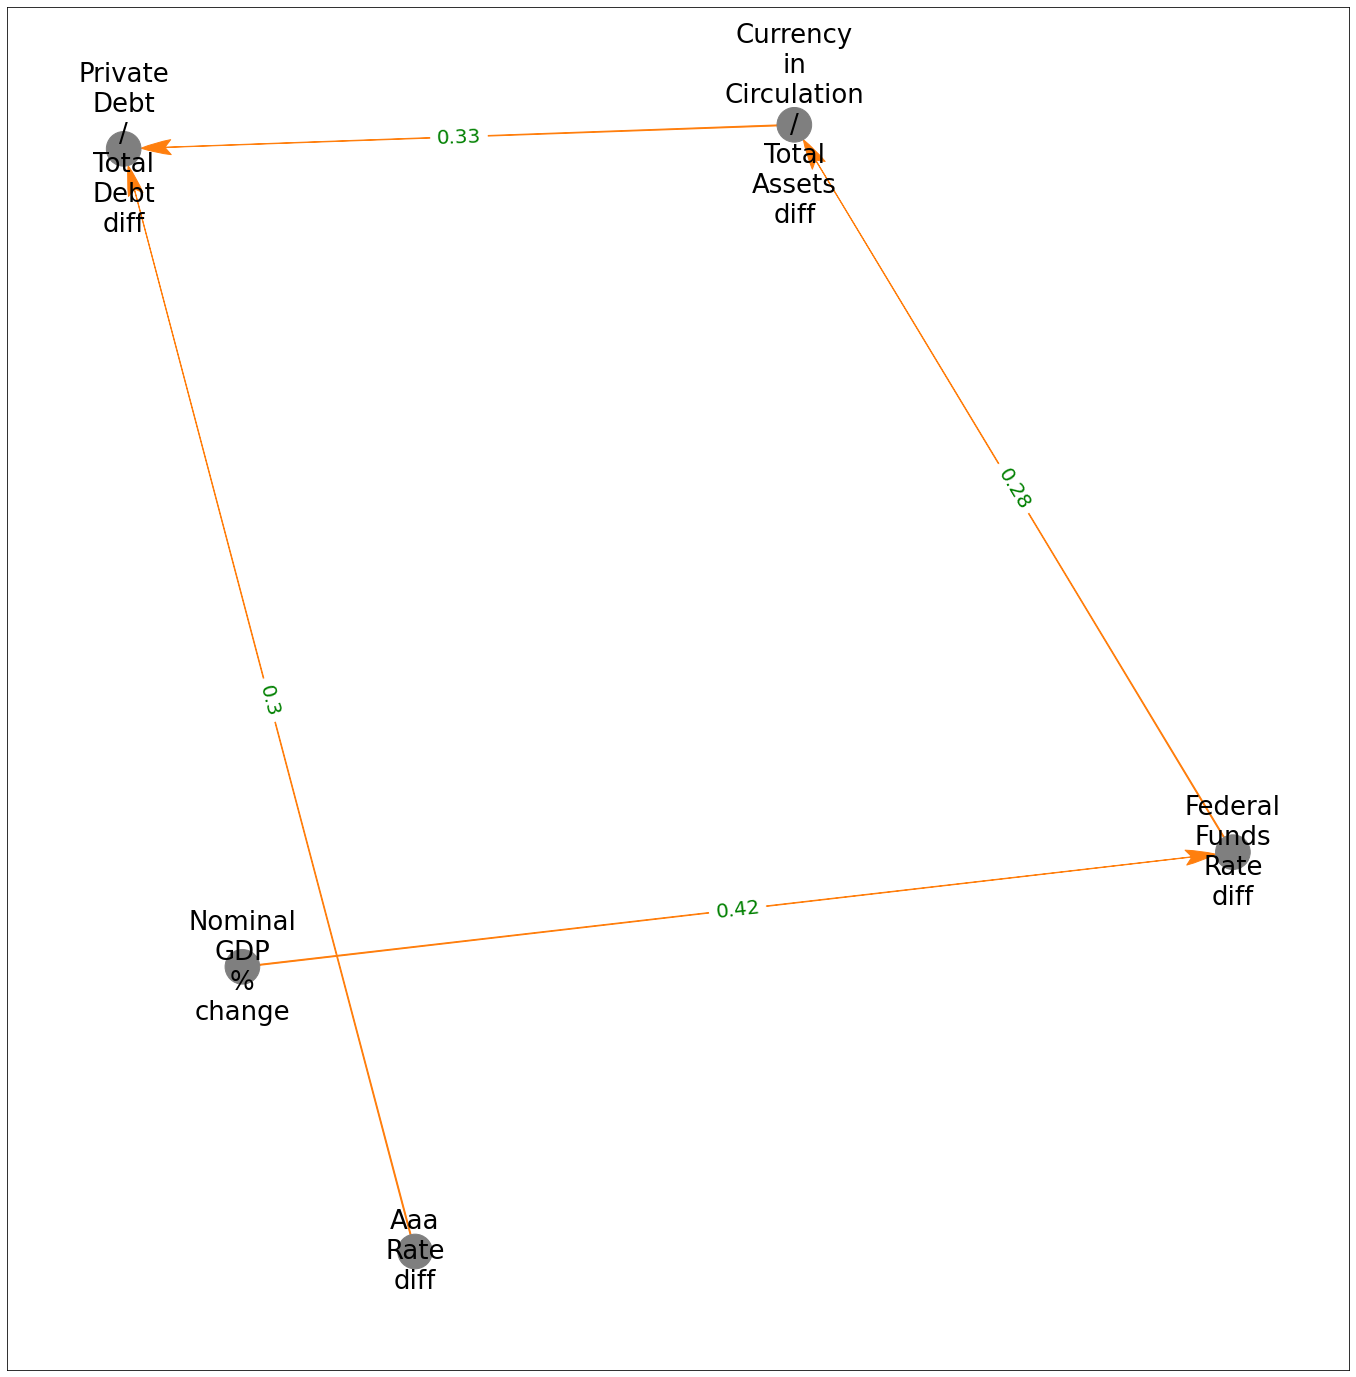

In [17]:
keys = ["Private Debt / Total Debt diff",
        "Nominal GDP % change", 
        "Federal Funds Rate diff",
        "Aaa Rate diff",
        "Currency in Circulation / Total Assets diff"]
pcorr_df, p_val_df = calculate_pcorr(data, keys)
dag_df = data[keys]
dag_df = dag_df.dropna().rename(
    columns={
        col:col.replace(" ", "\n") for col in keys})
variant = "parallel"
sig = 0.05
ci_test = "pearsonr"
c = PC(dag_df)
max_cond_vars = len(keys) - 2
model = c.estimate(return_type = "dag",variant= variant, 
                   significance_level = sig, 
                   max_cond_vars = max_cond_vars, ci_test = ci_test)
edges = model.edges()
graph_DAG(edges, dag_df)  